In [1]:
"""
Plot Fisher information estimated at each network layer, and bias in FI.
Based on the multivariate computation of FI that includes covariance matrix.
"""

import matplotlib.pyplot as plt
import os, sys
import numpy as np
from matplotlib import cm

import matplotlib.lines as mlines

##%% paths
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code', 'analysis_code'))
import load_activations
import plot_utils
colors_main, colors_sf = plot_utils.get_cmaps_biasCNN()
baseline_inds, card_inds, obl_inds, twent_inds = plot_utils.get_fi_bin_pars()

figfolder = os.path.join(root,'figures','FisherInfoPop')

In [2]:
# Parameters

# define which network to load (this analysis was only run for pretrained)

training_strs=['pretrained']

ckpt_strs=['0']
nInits_list = [1]
color_inds=[1]

# define other basic parameters
nImageSets_list = [4]
model='vgg16'
param_str='params1'
param_strs=[]
for ii in range(np.max(nInits_list)):    
  if ii>0:
    param_strs.append(param_str+'_init%d'%ii)
  else:
    param_strs.append(param_str)

dataset_str=['FiltIms14AllSFCos']
nTrainingSchemes = np.size(training_strs)

 # values of "delta" to use for fisher information
delta_vals = np.arange(1,10,1)
nDeltaVals = np.size(delta_vals)

info = load_activations.get_info(model, dataset_str[0])

# this set doesn't have different spat frequency levels, just broadband
sf_labels=['broadband SF']
nSF=1
sf=0

maxfeat = 8640

# how many PCs were combined to compute the measure? 
ncomp2do = np.arange(2,48,1)


In [3]:
#%% load the values for FI (calculated outside this code then saved)
all_fish_cov = []

# load activations for each training set of images (training schemes)
for tr in range(nTrainingSchemes):
  training_str = training_strs[tr]
  ckpt_num = ckpt_strs[tr]
  dataset_all = dataset_str[0]
  nInits = nInits_list[tr]
  nImageSets = nImageSets_list[tr]
  # different initializations with same training set
  for ii in range(nInits):
 
    param_str=param_strs[ii]
  
    # different versions of the evaluation image set (samples)
    for kk in range(nImageSets):
           
      if 'Filt' in dataset_all:
        dataset = '%s_rand%d'%(dataset_all,kk+1)
      elif kk==0:
        dataset = dataset_all
      else:
        dataset = '%s%d'%(dataset_all,kk)
        
      if ii==0 and kk==0:
        info = load_activations.get_info(model,dataset)
        layer_labels = info['layer_labels']
        nOri = info['nOri']
        ori_axis = np.arange(0, nOri,1)
        
      # find the exact number of the checkpoint 
#      ckpt_dirs = os.listdir(os.path.join(root,'code','fisher_info_cov',model,training_str,param_str,dataset))
      ckpt_dirs = os.listdir(os.path.join(root,'saved_analyses','fisher_info_cov',model,training_str,param_str,dataset))
      ckpt_dirs = [dd for dd in ckpt_dirs if 'eval_at_ckpt-%s'%ckpt_num[0:2] in dd and '_reduced_varyncomps' in dd]
      nums=[dir[np.char.find(dir,'-')+1:np.char.find(dir,'_reduced')] for dir in ckpt_dirs]            
  
      save_path = os.path.join(root,'saved_analyses','fisher_info_cov',model,training_str,param_str,dataset,'eval_at_ckpt-%s_reduced_varyncomps'%nums[0],'Fisher_info_cov_vary_ncomps.npy')
      print('loading from %s\n'%save_path)
      # Fisher info array is [nLayer x nSF x nOri x nDeltaValues] in size
      fi = np.load(save_path)

      if kk==0 and tr==0 and ii==0:
        nLayers = info['nLayers']         
        nOri = np.shape(fi)[2]      
        # initialize this ND array to store all Fisher info calculated values
        all_fish_cov = np.zeros([nTrainingSchemes, np.max(nInits_list), np.max(nImageSets_list), nLayers, nSF, nOri, len(ncomp2do), nDeltaVals])

      all_fish_cov[tr,ii,kk,:,sf,:,:,:] = np.squeeze(fi);


loading from /mnt/neurocube/local/serenceslab/maggie/biasCNN/saved_analyses/fisher_info_cov/vgg16/pretrained/params1/FiltIms14AllSFCos_rand1/eval_at_ckpt-0_reduced_varyncomps/Fisher_info_cov_vary_ncomps.npy

loading from /mnt/neurocube/local/serenceslab/maggie/biasCNN/saved_analyses/fisher_info_cov/vgg16/pretrained/params1/FiltIms14AllSFCos_rand2/eval_at_ckpt-0_reduced_varyncomps/Fisher_info_cov_vary_ncomps.npy

loading from /mnt/neurocube/local/serenceslab/maggie/biasCNN/saved_analyses/fisher_info_cov/vgg16/pretrained/params1/FiltIms14AllSFCos_rand3/eval_at_ckpt-0_reduced_varyncomps/Fisher_info_cov_vary_ncomps.npy

loading from /mnt/neurocube/local/serenceslab/maggie/biasCNN/saved_analyses/fisher_info_cov/vgg16/pretrained/params1/FiltIms14AllSFCos_rand4/eval_at_ckpt-0_reduced_varyncomps/Fisher_info_cov_vary_ncomps.npy



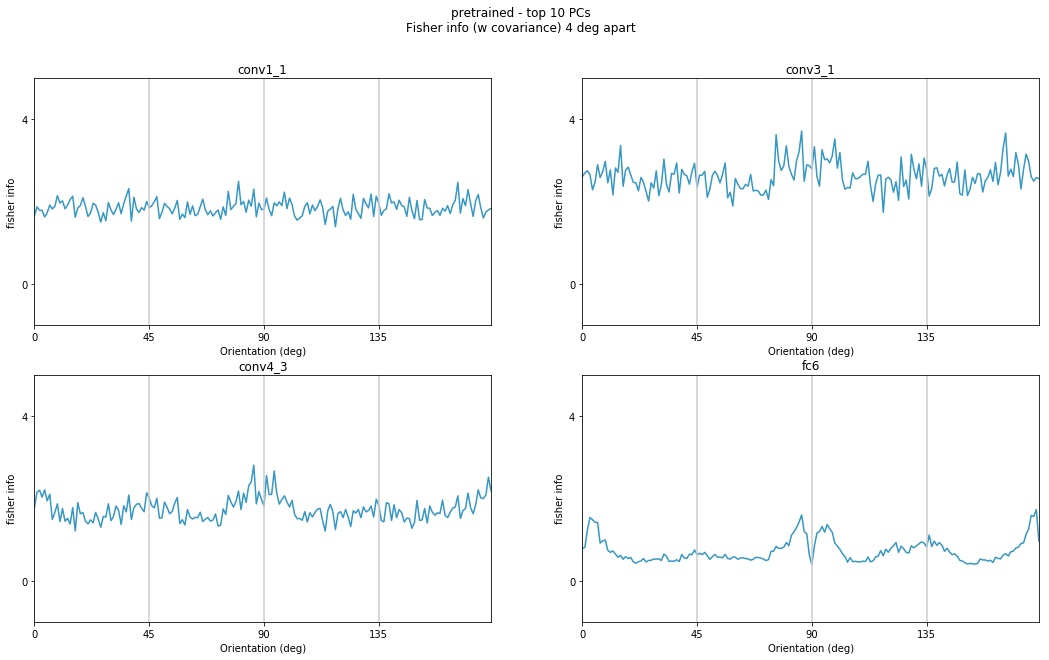

In [4]:
#%%  Plot Fisher information as a function of orientation, for some example layers.

# Figure 4A

ncomp2do = np.arange(2,48,1)
nn=8
layers2plot = np.asarray([0,6,12,18])
tr2plot=[0] 
init2plot = [0]

cols_grad = cm.Blues(np.linspace(0,1,6))
cols_grad=cols_grad[2:,:]

ii=0
dd=3

plt.rcParams['pdf.fonttype']=42
plt.rcParams.update({'font.size': 10})
plt.rcParams['ps.fonttype']=42    
plt.rcParams['figure.figsize']=[18,10]
ylimits = [-1,5]
plt.close('all')

plt.figure()
npx = np.ceil(np.sqrt(np.size(layers2plot)))
npy = np.ceil(np.size(layers2plot)/npx)

# loop over layers, making a subplot for each
for ll in range(np.size(layers2plot)):

  plt.subplot(npx,npy, ll+1)
  
  for tr in tr2plot:
  
    vals_all= np.zeros([nImageSets,nOri])
    
    for kk in range(nImageSets):
      
      vals= np.squeeze(all_fish_cov[tr,ii,kk,layers2plot[ll],sf,:,nn,dd])
      vals_all[kk,:] = vals
      
    # average over image sets
    meanvals = np.mean(vals_all,0)    
    errvals = np.std(vals_all,0)

#     plt.errorbar(ori_axis,meanvals,errvals,ecolor=colors_main[color_inds[tr],:],color=[0,0,0])
    plt.plot(ori_axis,meanvals,color=colors_main[color_inds[tr],:])
    
  plt.title('%s' % (layer_labels[layers2plot[ll]]))

  plt.xlabel('Orientation (deg)')
  plt.xticks(np.arange(0,181,45))
  plt.xlim([np.min(ori_axis),np.max(ori_axis)])
  plt.ylabel('fisher info')

  for xx in np.arange(0,181,45):
      plt.axvline(xx,color=[0.8, 0.8, 0.8])
  plt.ylim(ylimits)
  plt.yticks([0,4])
# finish up the entire plot   
plt.suptitle('%s - top %d PCs\nFisher info (w covariance) %d deg apart'% (training_strs[tr], ncomp2do[nn], delta_vals[dd]))
figname = os.path.join(figfolder, 'FIcov_pretrained_%dcomps.pdf'%ncomp2do[nn])
plt.savefig(figname, format='pdf',transparent=True)


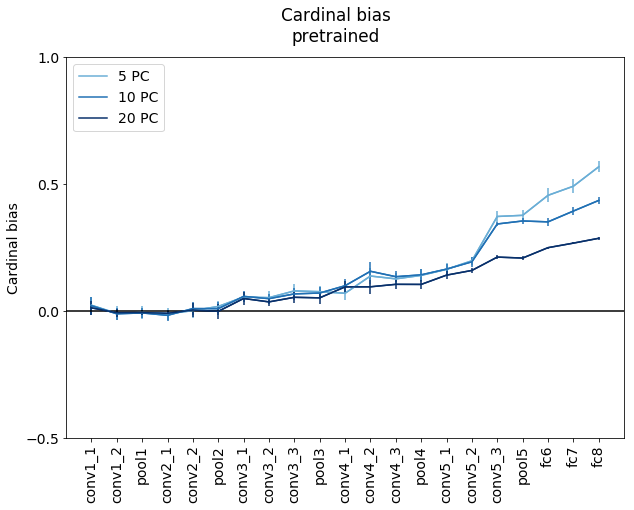

In [5]:
#%% Plot the cardinal bias across layers, for different ncomponents overlaid. 

# Figure 4B

ncomp2do = np.arange(2,48,1)
nn2plot = [3,8,18]

plt.rcParams.update({'font.size': 14})
plt.close('all')
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
handles = []
layers2plot = np.arange(0,nLayers,1)
dd=3
tr=0
cols_grad = cm.Blues(np.linspace(0,1,len(nn2plot)+2))
cols_grad=cols_grad[2:,:]
nInits=1
nImageSets=4
# loop over type of FIB - where are we looking for FI peaks?
for nn in range(len(nn2plot)):
  
  # matrix to store anisotropy index for each layer    
  all_vals = np.zeros([nInits,nImageSets,np.size(layers2plot)])
  
  # loop over network layers
  for ww1 in range(np.size(layers2plot)):
    # loop over network initializations
    for ii in range(nInits):
      # loop over image sets
      for kk in range(nImageSets):
        
        vals= all_fish_cov[tr,ii,kk,layers2plot[ww1],sf,:,nn2plot[nn],dd]
       
        base_discrim=  vals[baseline_inds]
        peak_discrim = vals[card_inds]
        
        all_vals[ii,kk,ww1] = (np.mean(peak_discrim) - np.mean(base_discrim))/(np.mean(peak_discrim) + np.mean(base_discrim))
      
  # average over image sets
  vals = np.mean(np.mean(all_vals,0),0)
  errvals = np.std(np.mean(all_vals,0),0)
  myline = mlines.Line2D(np.arange(0,np.size(layers2plot),1),vals,color = cols_grad[nn,:])
  ax.add_line(myline)   
  handles.append(myline)
  plt.errorbar(np.arange(0,np.size(layers2plot),1),vals,errvals,color=cols_grad[nn,:])


# finish up this subplot 
ylims = [-0.5,1]
xlims = [-1, np.size(layers2plot)]

plt.legend(['%d PC'%ncomp2do[nn] for nn in nn2plot],loc='upper left')

plt.plot(xlims, [0,0], 'k')
plt.xlim(xlims)
plt.ylim(ylims)
plt.yticks([-0.5,0, 0.5,1])
plt.ylabel('Cardinal bias')
plt.xticks(np.arange(0,np.size(layers2plot),1),[layer_labels[ii] for ii in layers2plot],rotation=90)

# finish up the entire plot
plt.suptitle('Cardinal bias\n%s'%(training_strs[tr]))  
fig.set_size_inches(10,7)
figname = os.path.join(figfolder, 'FIBcov_pretrained_varyncomps.pdf')
plt.savefig(figname, format='pdf',transparent=True)
